## **Machine Learning (Support Vector Machine)**

# Loading Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn import svm
from sklearn.svm import SVC

# Loading codebook file

In [ ]:
def load_codebook(fname):
  df = pd.read_csv(fname)
  y = df[["x0", "x1", "x2", "x3", "x4", "x5", "x6"]].values
  m = df[["m0", "m1", "m2", "m3"]].values
  file_size = y.shape[0]
  m_modified = np.zeros(file_size)
  for i in range(file_size):
    m_modified[i] += m[i,0]*8+m[i,1]*4+m[i,2]*2+m[i,3]*1
  return y, m_modified, file_size

# Split data

Splitting data into training and testing

In [ ]:
def splitting_data(y,m,rate,file_size):
  train_size = round(file_size*rate)
  test_size = file_size - train_size
  train_y = y[0:train_size,:]
  train_m = m[0:train_size]
  test_y = y[train_size:file_size,:]
  test_m = m[train_size:file_size]
  return train_y, train_m, test_y, test_m, train_size, test_size


# Support Vector Machine

In [ ]:
def SVM(data, target, class0, class1, kernel_type):
  idx = []
  dataset = []
  targetset = []
  for i in range(len(data)):
      if target[i] == class0 or target[i] == class1:
          idx.append(i)
          dataset.append(data[i])
          if target[i] == class0:
              targetset.append(-1)
          else:
              targetset.append(1)
  clf = SVC(kernel=kernel_type) #linear
  #--
  clf.fit(dataset, targetset)
  
  #--?
  alpha = clf.dual_coef_  #alpha
  sv = clf.support_vectors_
  w = np.dot(alpha, sv)
  w0 = clf.intercept_
  return w, w0

# Predict Function

In [ ]:
def predict_function(data, class0, class1, w, w0, cal_class, dist, data_size):
  for i in range(data_size):
    g = np.dot(w, data[i].T) + w0
    if g < 0:
        cal_class[i,class0] += 1
        if abs(g) > dist[i,class0]:
            dist[i,class0] = abs(g)
    else:
        cal_class[i,class1] += 1 #投票
        if abs(g) > dist[i,class1]:
            dist[i,class1] = abs(g)
  return cal_class, dist

# ClassMapping

In [ ]:
def class_mapping(cal_class, dist, data_size):
  class_hat = np.zeros(data_size)
  m_hat = np.zeros((data_size,4))
  for i in range(data_size):
    # determine is there classes have same vote
    tmp = cal_class[i]
    num_of_max_term = len(tmp[tmp==np.max(tmp)])
    
    # print(tmp==np.max(tmp))  #[False False False False False False False False False False False False False  True False False]
    # print(len(tmp[tmp==np.max(tmp)]))

    # get the most votes message
    if num_of_max_term == 1:
      class_hat[i] = np.argmax(tmp)
    # check the distance to get the most votes message
    else:
      tmp_dist = dist[i]
      class_hat[i] = np.argmax(tmp_dist)  #returns the index of the maximum value
    # transform class to message
    m_hat[i,0] = class_hat[i]//8
    m_hat[i,1] = (class_hat[i]-m_hat[i,0]*8)//4
    m_hat[i,2] = (class_hat[i]-m_hat[i,0]*8-m_hat[i,1]*4)//2
    m_hat[i,3] = class_hat[i]-m_hat[i,0]*8-m_hat[i,1]*4-m_hat[i,2]*2
  return m_hat
  # 看誰的票最多

# Calculate Error

In [ ]:
def calculate_error(m_hat,m_class,file_size):
  block_err = 0
  bit_err = 0
  for i in range(file_size):
    m = np.zeros(4)
    # transform class to message
    m[0] = m_class[i]//8
    m[1] = (m_class[i]-m[0]*8)//4
    m[2] = (m_class[i]-m[0]*8-m[1]*4)//2
    m[3] = m_class[i]-m[0]*8-m[1]*4-m[2]*2
    if (m_hat[i,:] != m).any():
      block_err += 1
    for j in range(4):
      if m_hat[i,j] != m[j]:
        bit_err += 1
  return block_err, bit_err

# Main Function

0 / 6
1 / 6
2 / 6
3 / 6
4 / 6
5 / 6
6 / 6


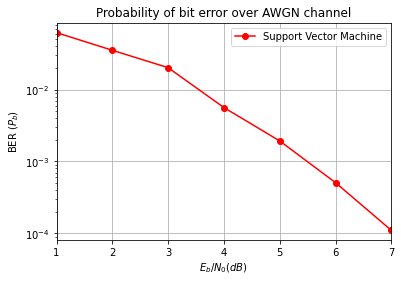

Bit Error Rate: [0.06225    0.035375   0.02025    0.0056375  0.00193304 0.0005075
 0.00011   ]


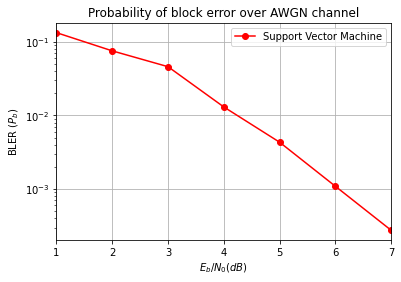

Block Error Rate: [0.1335    0.0755    0.046     0.01305   0.0043294 0.00109   0.000275 ]
Compile by TA


In [ ]:
SNR_start = 1
SNR_end = 7
step_size = 1
SNR = np.arange(SNR_start,SNR_end+1,step_size)
length_SNR = len(SNR)
BLER = np.zeros(length_SNR)
BER = np.zeros(length_SNR)
rate = 0.5 # training data rate
for i in range(length_SNR):
  fname = "codeword_file_SNR="+str(SNR[i])+".csv"
  [y,m,file_size] = load_codebook(fname)
  [train_y,train_m,test_y,test_m,train_size,test_size] = splitting_data(y,m,rate,file_size)
  kernel_linear = 'linear'
  cal_class = np.zeros((test_size,16))
  dist = np.zeros((test_size,16))
  for class0 in range(16):
    for class1 in range(class0+1,16):
      [w, w0] = SVM(train_y, train_m, class0, class1, kernel_linear)
      [cal_class, dist] = predict_function(test_y, class0, class1, w, w0, cal_class, dist, test_size)
  m_hat = class_mapping(cal_class, dist, test_size)
  [block_err, bit_err] = calculate_error(m_hat,test_m, test_size)
  BER[i] = bit_err/4/test_size
  BLER[i] = block_err/test_size
  print(i,"/",len(SNR)-1)
# Fig plot
EbN0dBs = np.arange(start=SNR_start,stop=SNR_end+1,step=step_size)
fig1 = plt.figure()
plt.semilogy(EbN0dBs,BER,color='r',marker='o',linestyle='-',label='Support Vector Machine')
plt.xlabel('$E_b/N_0(dB)$');plt.ylabel('BER ($P_b$)')
plt.title('Probability of bit error over AWGN channel')
plt.xlim(SNR_start,SNR_end);plt.grid(True);
plt.legend()
plt.show()
print("Bit Error Rate:", BER)
fig2 = plt.figure()
plt.semilogy(EbN0dBs,BLER,color='r',marker='o',linestyle='-',label='Support Vector Machine')
plt.xlabel('$E_b/N_0(dB)$');plt.ylabel('BLER ($P_b$)')
plt.title('Probability of block error over AWGN channel')
plt.xlim(SNR_start,SNR_end);plt.grid(True);
plt.legend()
plt.show()
print("Block Error Rate:", BLER)
print("Compile by TA")
  